In [1]:
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import data_preprocessing
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#from tsfresh import extract_features


In [8]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.3.2 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [76]:
def csv_to_json(csv_file_path, json_file_path):
    # Read the CSV data
    df = pd.read_csv(csv_file_path)

    # Convert the CSV data to JSON
    json_data = df.to_json(orient='records')

    # Write the JSON data to a file
    with open(json_file_path, 'w') as json_file:
        json_file.write(json_data)
    



In [78]:
path_dataset = r'small_dataset.csv'
path_json = r'C:\Users\fiete\PycharmProjects\boxklassifikation\Boxschlag-Klassifikation\set1.json'
csv_to_json(path_dataset, path_json)

In [ ]:
# Normalisierung der Daten
"""
Gerne mit periodLengthMS und sampling sampleRateUS rumspielen. Den Effekt von den Variablen könnt ihr in smartPunch_tutorial_ManipulatePeriodLength.ipynb sehen.  
"""
import json
import prepro

periodLengthMS = 1000
sampleRateUS = 1000


with open('max_dataset.json', 'r') as f:
    dsds = json.load(f)





ds = prepro.jsonData_to_dataset_in_timedifference_us(dsds)

df_new = prepro.normate_dataset_period(periodLengthMS, sampleRateUS, ds)

moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin
moin


In [3]:
df = pd.DataFrame({'idx': range(len(df_new)), 'dfs': df_new})

In [4]:
gerade = []
kinnhaken = []
kopfhaken = []

#size_of_trainset = int(len(df) * 0.2)
#count_per_label = int(size_of_trainset / 3)


for i in range(len(df)):
    if(df.iloc[i][1].iloc[1].label == "Gerade"):
        kopfhaken.append(df.iloc[i][1])
    elif(df.iloc[i][1].iloc[1].label == "Kinnhaken"):
        kinnhaken.append(df.iloc[i][1])
    elif(df.iloc[i][1].iloc[1].label == "Kopfhaken"):
        gerade.append(df.iloc[i][1])


traindata = gerade+ kinnhaken+ kopfhaken

print(len(traindata))

295


In [5]:
x_train,y_train = [],[]

for df in traindata:
    y_train.append(df["label"].iloc[0])
    x_train.append(df.drop(columns=["timestamp", "label"]).values)

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape, y_train.shape

((295, 1001, 3), (295,))

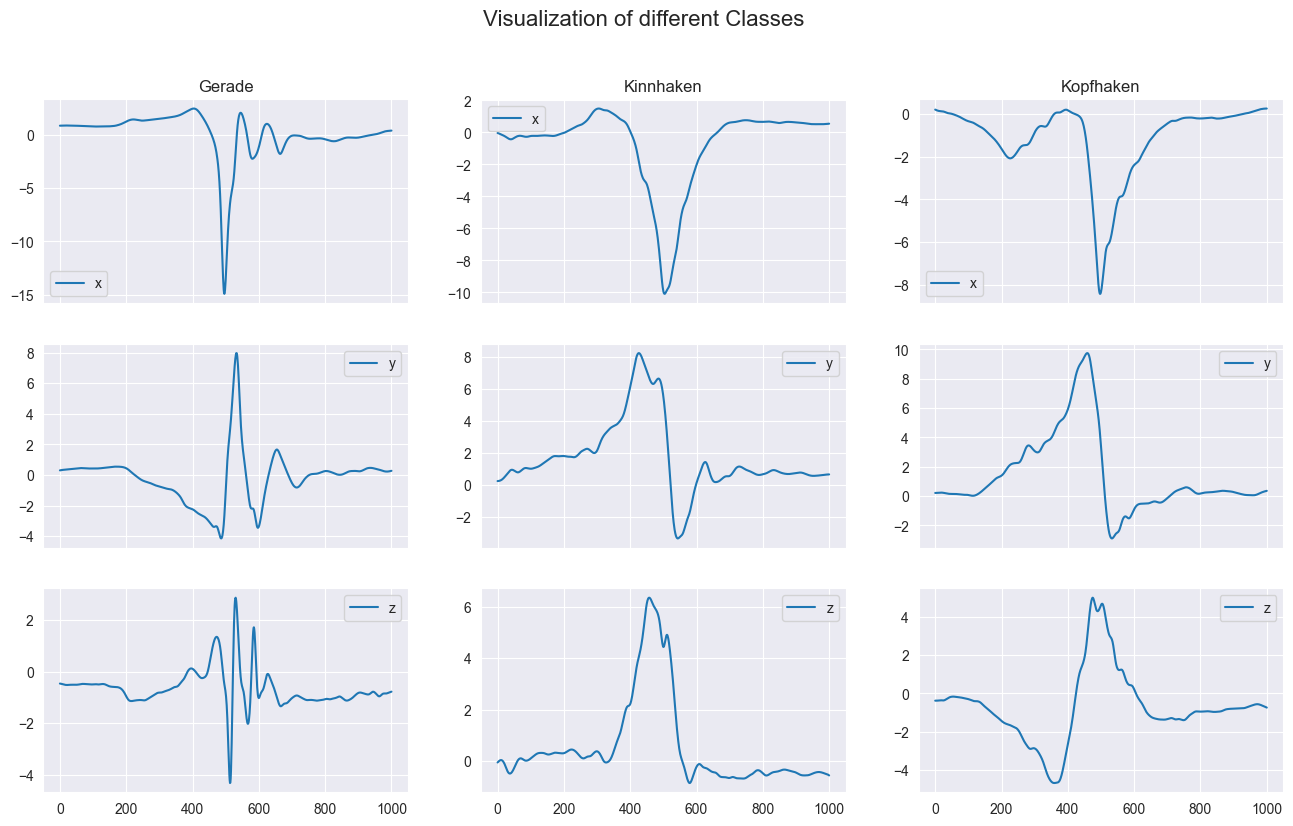

In [6]:
LABELS = ['Gerade', 'Kinnhaken', 'Kopfhaken']
# Set classes to visualize and set the feature names
FEATURE_NAMES = ['x', 'y', 'z']
CLASSES = ['Gerade', 'Kinnhaken', 'Kopfhaken']

fig, axs = plt.subplots(nrows=3, ncols=len(CLASSES), sharex=True, sharey=False)
fig.suptitle('Visualization of different Classes', fontsize=16)
fig.set_size_inches(16, 9)
x = np.arange(1001)
for index, cls in enumerate(CLASSES):
    # Set class as label for top subplot of each column
    axs[0][index].set(title=cls)
    # Get random instance from training data with corresponding class
    instance_index = np.random.choice(np.argwhere(y_train == cls).flatten())
    instance = x_train[instance_index]
    # Plot the feature groups (all axis of one measurement) in the different subplots and add labels
    for sublot in [0, 1, 2]:
        axs[sublot][index].plot(x, instance[:, sublot])
        axs[sublot][index].legend(FEATURE_NAMES[sublot])
plt.show()

In [7]:
_label = ['Gerade', 'Kinnhaken', 'Kopfhaken']
category_to_num = {element: num for num, element in enumerate(_label)}
numerical_data = np.vectorize(category_to_num.get)(y_train)


y_train  = np.array(numerical_data)

In [52]:
#---------------------------------------------RNN BY NILS

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import LSTM, Dense, Masking, Input


"""

"""
# Definiere das Modell
model0 = keras.models.Sequential([
    InputLayer(shape=x_train[1].shape),
    SimpleRNN(units=256, activation='relu', return_sequences=True),
    Dropout(rate=0.2),  # Dropout zur Regularisierung
    SimpleRNN(units=256, activation='relu', return_sequences=False),
    Dropout(rate=0.2),  # Dropout zur Regularisierung
    Dense(3, activation='softmax')  # Ausgangsschicht für 3 Klassen
])

model0.compile(optimizer=Adam(learning_rate=0.001),  # Angepasste Lernrate
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])



# Zusammenfassung des Modells ausdrucken
print(model0.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 1001, 256)      │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1001, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,659 (776.01 KB)

 Trainable params: 198,659 (776.01 KB)

 Non-trainable params: 0 (0.00 B)

None


In [66]:
#--------------------------testing RNNs
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import LSTM, Dense, Masking, Input

from tensorflow.keras import layers


# Definiere das Modell
model1 = keras.models.Sequential()
model1.add(InputLayer(shape=x_train[1].shape))
model1.add(LSTM(128, dropout=0.2, return_sequences=True, activation = "relu"))
#model1.add(LSTM(128, dropout=0.2, return_sequences=True, activation = "relu"))
model1.add(LSTM(128, dropout=0.2, return_sequences=False, activation = "relu"))
model1.add(Dense(3, activation="softmax"))  #Output und Input müssen am Ende die selbe shape haben -> mittlere Spalte der Tabelle 


model1.compile(optimizer=Adam(learning_rate=0.001),  # Angepasste Lernrate
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])



# Zusammenfassung des Modells ausdrucken
print(model1.summary())

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 1001, 128)      │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,555 (779.51 KB)

 Trainable params: 199,555 (779.51 KB)

 Non-trainable params: 0 (0.00 B)

None


array([[ 3,  0, 15],
       [ 1, 19,  0],
       [ 0,  1, 20]], dtype=int64)

array([1, 2, 0, 0, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 2, 0, 2, 2, 1, 0, 0, 0,
       2, 2, 2, 1, 0, 0, 2, 1, 0, 2, 2, 1, 0, 0, 0, 2, 2, 1, 0, 0, 1, 0,
       0, 2, 1, 0, 1, 2, 2, 0, 0, 2, 1, 2, 1, 2, 0])

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - accuracy: 0.3390 - loss: 25793585009917952.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to bestpractice.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.3390 - loss: 25793585009917952.0000 - val_accuracy: 1.0000 - val_loss: nan
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.1737 - loss: nan
Epoch 2: val_accuracy did not improve from 1.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step - accuracy: 0.1737 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.1737 - loss: nan
Epoch 3: val_accuracy did not improve from 1.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - accuracy: 0.1737 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.1737 - loss: nan
Epoch 4: val_accuracy did not improve from 1.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - accuracy: 0.1737 - loss: nan - val_a

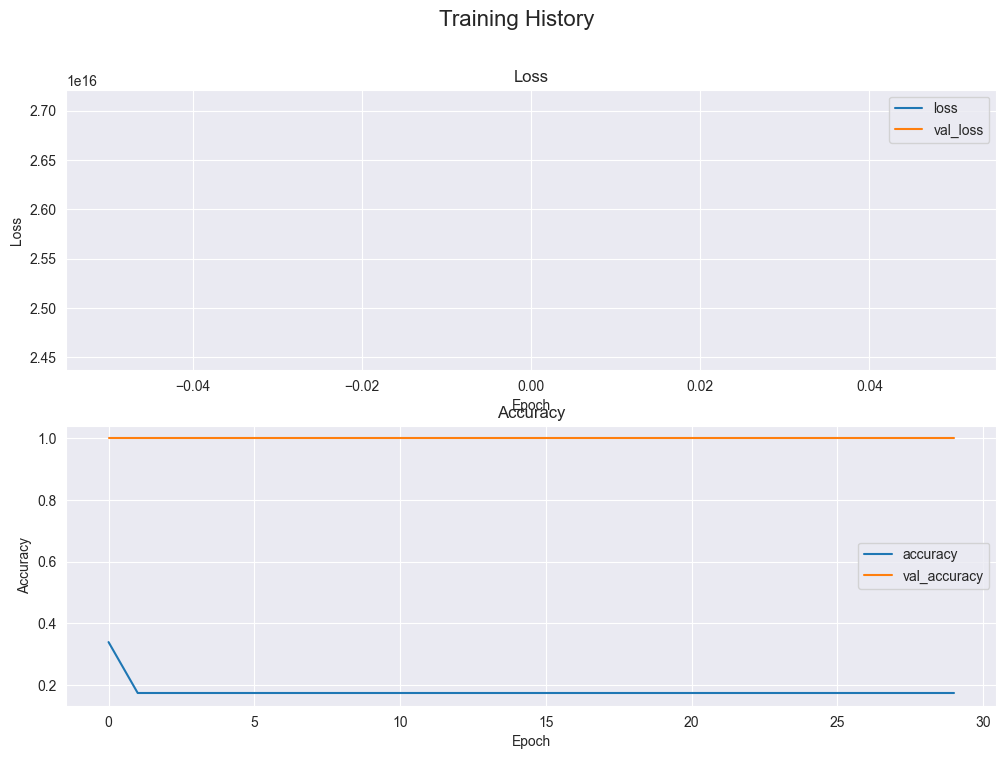

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Embedding,LSTM





# Set parameters for data splitting and training
TEST_SIZE = 0.2
BATCH_SIZE = 512
EPOCHS = 30


# Encode the labels using One-Hot-Encoding
y_train_encoded = tf.one_hot(indices=y_train, depth=3)

checkpoint_filepath = 'bestpractice.weights.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose = 1)





# Train model using validation split
history = model1.fit(x=x_train, y=y_train_encoded, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[model_checkpoint_callback])


# Plot the training histroy
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()



In [68]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

sk_X_train, sk_X_test, sk_y_train, sk_y_test = train_test_split(x_train, y_train, test_size=0.2)
y_pred = model1.predict(sk_X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
#y_true = np.argmax(sk_y_test, axis=1)
conf_matrix = confusion_matrix(sk_y_test, y_pred_labels)
conf_matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


array([[18,  0,  0],
       [17,  0,  0],
       [24,  0,  0]], dtype=int64)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step


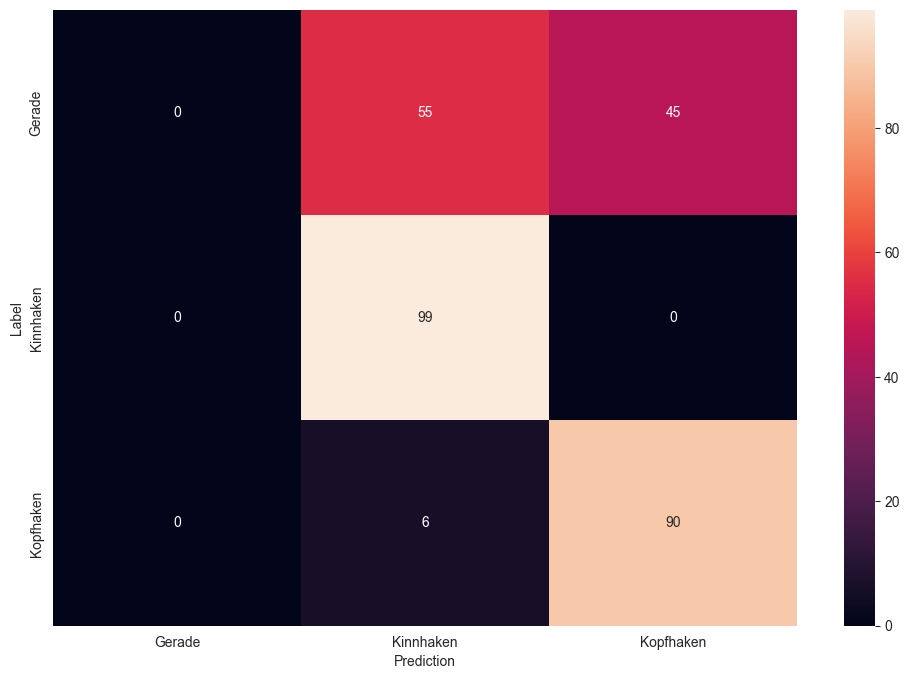

In [57]:
y_predicted = np.argmax(model1.predict(x=x_train), axis=1)
confusion_matrix = tf.math.confusion_matrix(labels=y_train, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
model.